![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Regressão periódica

## Dados

Nesta primeira parte iremos ajustar uma curva aos dados de demanda elétrica fornecidos pelo ONS,
para o período entre os dias *16.04.2018 - 16.05.2018*.

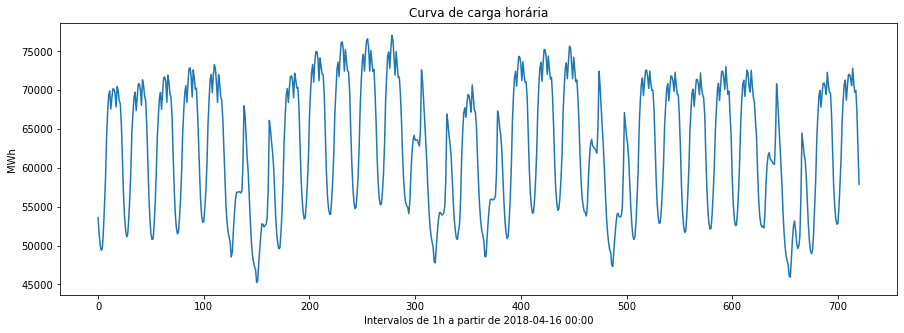

In [2]:
cch = np.load('Demanda_16.04.2018-16.05.2018.npz')
ys = cch['Demanda']
ts = np.arange(len(ys))

plt.figure(figsize=(15,5))
plt.plot(ts,ys)
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

Vamos pegar um intervalo com dias úteis.

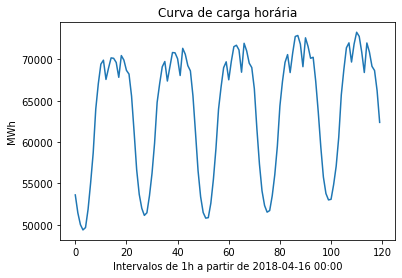

In [3]:
tmax = 120

plt.plot(ts[:tmax],ys[:tmax])
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

# Parte 1: Ajuste simples

## Questão 1: Matriz da regressão

O que salta aos olhos é o comportamento aproximadamente periódico,
logo uma primeira idéia é ajustar um modelo com funções também periódicas.

Um ajuste simples é o seguinte:
$$y(t) = c_0 + c_1\sin\left(\frac{2\pi t}{24}\right) + c_2\cos\left(\frac{2\pi t}{24}\right)$$

Explique porque o denominador 24 faz sentido para estes dados que temos.

Por que 24 horas é o maior período (me esqueci da terminologia formal) para o qual cada curva tem um formato aproximadamente senoidal. É que se a ideia for aproximar a curva por uma combinação de funções periódicas, primeiro se ajusta a menor frequência (acho que se fala sobre frequência fundamental) e depois se ajusta melhor a curva nos pontos intermediários somando funções de frequência maior, múltiplas da fundamental.

Escreva a função `make_trig_matrix(ts,p)`, que monta a matriz de regressão $X$ tal que $Xc = y$ para o modelo proposto acima para `ts` e com período `p`.

**Observações:**
- A função constante está na base;
- A ordem das colunas importa para os asserts (mas não para o ajuste, se você sabe o que faz).
  Assim, as colunas devem vir na ordem das funções: constante, seno, cosseno.

In [4]:
def make_trig_matrix(ts,p):
    """ Retorna a matriz de regressão para o modelo y(t) = c0 + c1*sin(2*pi*t/p) + c2*cos(2*pi*t/p). """
    matrix = list()
    for t in ts:
        x = 2*np.pi*t/p # calcula o x de uma vez só
        new_line = [1, np.sin(x), np.cos(x)] # adiciona os valores em cada linha que vai ser adicionada à matriz depois
        matrix.append(new_line)
    return np.array(matrix)

# a matriz fica tipo:
# [[1, sen(a0), cos(a0)]
#  [1, sen(a1), cos(a1)]
#  ...
#  [1, sen(an), cos(an)]]

In [5]:
tss = np.linspace(-2*np.pi,2*np.pi,51)
X = make_trig_matrix(tss,np.pi)

assert all([np.isclose(X[i][0],1) for i in range(10)])

In [6]:
# Testes de periodicidade

assert np.allclose(X[0][1],X[-1][1])
assert np.allclose(X[0][1],X[len(tss)//2][1])
assert np.allclose(X[0][2],X[-1][2])
assert np.allclose(X[0][2],X[len(tss)//2][2])

## Questão 2: Gráficos

Faça o gráfico tanto dos dados como do ajuste do modelo,
usando apenas as 120 primeiras observações, que correspondem aos primeiros cinco dias úteis.

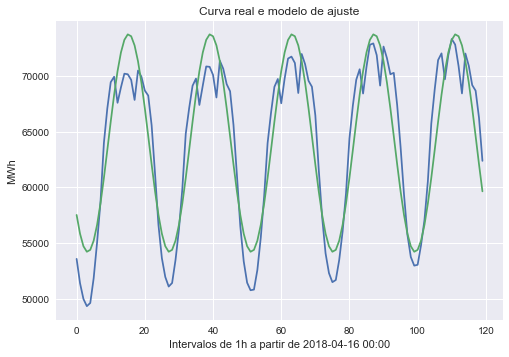

In [7]:
def modelo_de_ajuste(c0, c1, c2, t): # em toda a lista vou fazer isso: obter os coeficientes e jogar no modelo
    x = 2*np.pi*t/24
    return c0 + c1*np.sin(x) + c2*np.cos(x)

plt.style.use('seaborn')

M = make_trig_matrix(ts[:120], 24)
coefs, *_ = np.linalg.lstsq(M, ys[:120], rcond=None)
ys_ajuste = modelo_de_ajuste(coefs[0], coefs[1], coefs[2], ts[:120])

plt.plot(ts[:120], ys[:120], label='Dados reais')
plt.plot(ts[:120], ys_ajuste, label='Modelo de ajuste')
plt.title('Curva real e modelo de ajuste')
plt.ylabel('MWh')
plt.xlabel('Intervalos de 1h a partir de 2018-04-16 00:00')

ax = plt.gca()
plt.show()

In [8]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

yss = [ax.lines[i].get_ydata() for i in range(2)]

assert 73000 <= np.max(yss) <= 73800
assert 49000 <= np.min(yss) <= 50000

In [9]:
ax = None

Plote também o residual (erro de ajuste)!

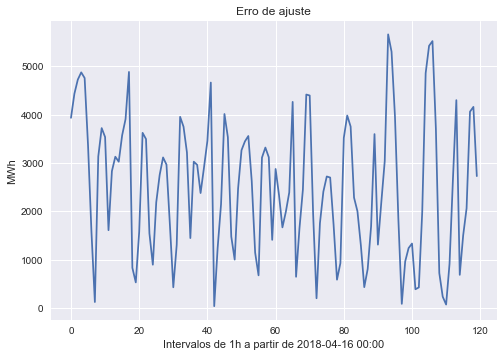

In [10]:
plt.plot(ts[:120], np.abs(ys_ajuste - ys[:120]))
plt.title('Erro de ajuste')
plt.ylabel('MWh')
plt.xlabel('Intervalos de 1h a partir de 2018-04-16 00:00')

ax = plt.gca()
plt.show()

In [11]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [12]:
ax = None

Esse gráfico reflete alguma tendência nos dados que difere do ajuste?
Se sim qual função poderia ser acrescentada a base do modelo para tentar capturar essa tendência?

Ele parece mostrar que os erros assumem máximos em mínimos alternados. Não com a mesma 'intensidade' mas com uma certa regularidade e periodicidade, talvez. Umas funções que poderiam ser acrescentadas à base pra tentar capturar essa tendência talvez seriam mais uma seno e uma cosseno, mas de menores períodos.

O que mais você percebe no gráfico de erros?

Que a distribuição dos erros parece ser mais ou menos uniforme em todo o intervalo. Quero dizer: não tem **um** intervalo que se distoa dos outros e onde os erros se concentram. Os erros variam, mas ficam mais ou menos na mesma faixa.

Eu também estranho um pouco o fato de terem erros da ordem de $5000$. Fico pensando se isso não está errado.

## Questão 3: Uma base maior

Agora, vamos tentar um ajuste com mais funções (também ditas _harmônicos_):
$$y(t) = \alpha_0 +  \sum_{i=1}^k\alpha_i \sin\left(\frac{2\pi it}{24}\right) + \sum_{i=1}^k\beta_i \cos\left(\frac{2\pi it}{24}\right).$$

Para te auxiliar nessa tarefa escreva a função
- `make_full_trig_matrix(ts,p,i_max)`: Semelhante a `make_trig_matrix`, mas retorna a matriz para o ajuste acima,
  correspondente ao conjunto de harmônicos de $i=1$ até $i = i_\max$.

In [13]:
def make_full_trig_matrix(ts,p,imax):
    matrix = list()
    for t in ts:
        new_line = list([1]) # adiciona o 1 sozinho de começo
        for i in range(1, imax + 1): # pra cada harmônico adiciona um seno e um cosseno
            x = 2*np.pi*i*t/24 # calcula uma vez só
            new_line.append(np.sin(x))
            new_line.append(np.cos(x))
        matrix.append(new_line)
    return matrix

In [14]:
# Teste de sanidade
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 1)
Y = make_trig_matrix(tss, 24)

for i in range(5):
    for j in range(3):
        assert np.isclose(X[i][j],Y[i][j])

In [15]:
# Teste de dimensão
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 3)
assert np.shape(X) == (100,7)

## Questão 4: Gráficos de novo

Faça o gráfico do ajuste para $i_\max = 2$, novamente para os 5 primeiros dias úteis.

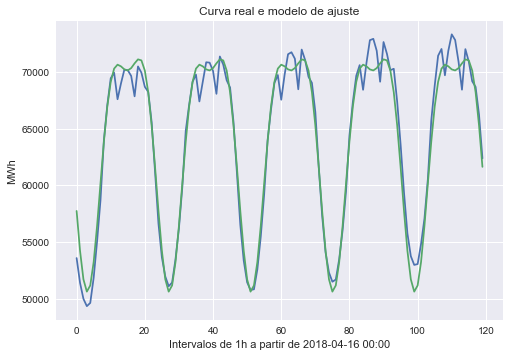

In [16]:
# pode parecer viagem, mas é só o algoritmo generalizado, é pra evitar retrabalho futuro
def modelo_de_ajuste2(coefs, imax, t):
    summ = coefs[0] # já soma a constante
    for i in range(1, imax+1): # pra cada i soma um seno e um cosseno
        summ += coefs[2*i-1]*np.sin(2*np.pi*i*t/24) + coefs[2*i]*np.cos(2*np.pi*i*t/24)
    return summ

M_regress = make_full_trig_matrix(ts[:120], 24, 2)
c, *_ = np.linalg.lstsq(M_regress, ys[:120], rcond=None)

ys_ajuste_2 = modelo_de_ajuste2(c, 2, ts[:120]) # y de ajuste segue o modelo anterior. o modus operandi aqui é esse

plt.plot(ts[:120], ys[:120], label='Dados reais')
plt.plot(ts[:120], ys_ajuste_2, label='Modelo de ajuste')
plt.title('Curva real e modelo de ajuste')
plt.ylabel('MWh')
plt.xlabel('Intervalos de 1h a partir de 2018-04-16 00:00')

ax = plt.gca()
plt.show()

In [17]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

for i in range(2):
    yss = ax.lines[i].get_ydata()
    assert 71000 <= np.max(yss) <= 73300
    assert 49000 <= np.min(yss) <= 51300

In [18]:
ax = None

E não se esqueça do residual.

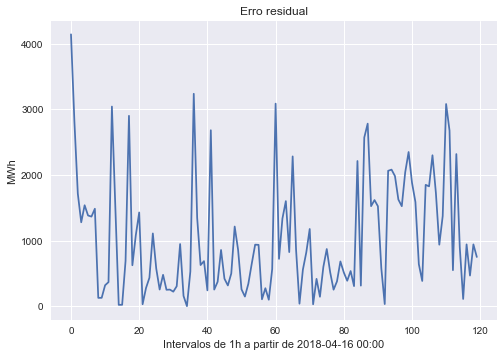

In [19]:
plt.plot(ts[:120], np.abs(ys_ajuste_2 - ys[:120]))
plt.title('Erro residual')
plt.ylabel('MWh')
plt.xlabel('Intervalos de 1h a partir de 2018-04-16 00:00')

ax = plt.gca()
plt.show()

In [20]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [21]:
ax = None

Agora, faça o gráfico do erro para $i_\max = 5$, $6$ e $10$, lado a lado.

**Dica:** Faça uma função `graph_err(imax, tmax)` que faz o gráfico do erro do ajuste em função de imax e tmax,
e use `subplot(n,m,k)` para selecionar o eixo.

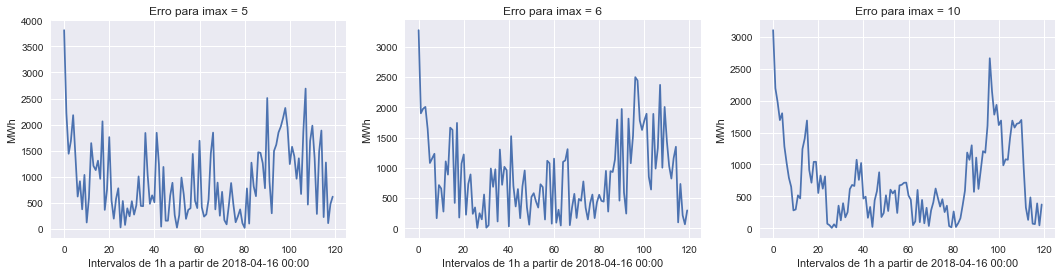

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))

list_imax = [5, 6, 10]

def graph_err(imax, tmax):

    full_regression_matrix = make_full_trig_matrix(ts[:tmax], 24, imax)
    c, *_ = np.linalg.lstsq(full_regression_matrix, ys[:tmax], rcond=None)

    ys_ajuste_imax = modelo_de_ajuste2(c, imax, ts[:tmax])
    erro = np.abs(ys[:tmax] - ys_ajuste_imax)

    index = list_imax.index(imax) + 1
    # esse index acima é o do gráfico. não deve ser confundido com índice de lista. esse assume os valores [1, 2, 3]
    plt.subplot(1, 3, index) # é pra colocar aqui
    plt.plot(ts[:tmax], erro)
    plt.ylabel("MWh")
    plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00")
    plt.title(f'Erro para imax = {imax}')

for imax in list_imax:
    graph_err(imax, tmax)

plt.show()

O que você muda e o que não muda ao aumentar $i_\max$?

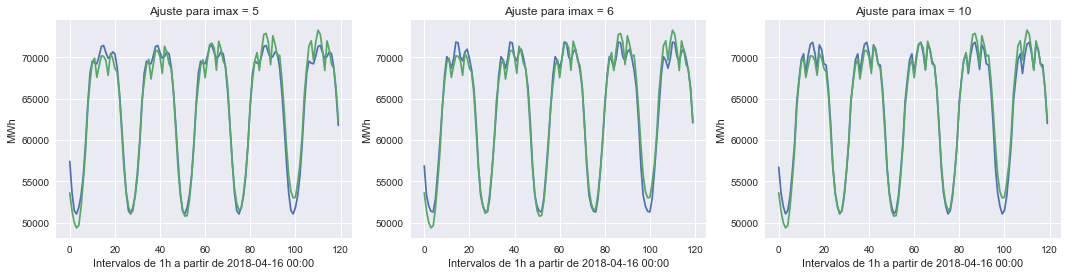

In [23]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))

list_imax = [5, 6, 10]

def graph_err(imax, tmax):

    full_regression_matrix = make_full_trig_matrix(ts[:tmax], 24, imax)
    c, *_ = np.linalg.lstsq(full_regression_matrix, ys[:tmax], rcond=None)

    ys_ajuste_imax = modelo_de_ajuste2(c, imax, ts[:tmax])
    erro = np.abs(ys[:tmax] - ys_ajuste_imax)

    index = list_imax.index(imax) + 1
    plt.subplot(1, 3, index)
    plt.plot(ts[:tmax], ys_ajuste_imax)
    plt.plot(ts[:tmax], ys[:tmax])
    plt.ylabel("MWh")
    plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00")
    plt.title(f'Ajuste para imax = {imax}')

for imax in list_imax:
    graph_err(imax, tmax)

plt.show()

Aumentando $i_\max$ a gente consegue aumentar os máximos e mínimos da curva e acertar um pouco os erros que houverem entre eles, se os erros também forem mais ou menos periódicos, mas é importante reparar que quando se faz isso esse ajuste acontece em todas as ondas igualmente. Então, com a nossa função de ajuste até agora é impossível acertar, por exemplo, aquele valor abaixo de 50000 no começo do intervalo e cada um dos valores mínimos (que ficam entre 50000 e 55000) ao mesmo tempo. Até dá pra reduzir um pouco a quantidade de ruídos e suavizar a curva de erro ao longo do intervalo.

Acho que o problema maior mesmo parece ser que por mais que a gente esteja aproximando as curvas por funções periódicas, os dados coletados em si não são periódicos, mesmo que se pareçam, então qualquer tentativa de correção de erro fica prejudicada por isso. Há ruídos e irregularidades em qualquer trecho que as funções até agora não conseguem capturar. Por exemplo, dá pra reparar que em relação à curva de ajuste, que é uma soma de senoides, a curva real dá uma 'subidinha'. Capturar isso aí só com a combinação de senoides usando o período maior como 24 horas é impossível, talvez somando um $f(x) = kx$ a isso, ou outra coisa pra pegar essa inclinação tenha algum jeito.

# Parte 2: Ajuste misto

## Questão 5: Polinômios e funções trigonométricas

Vamos adicionar polinômios à base, e comparar o erro de regressão obtido com uma base um pouco maior.

Comece implementando a função `make_poly_matrix(ts, d_max)`,
que retorna a matriz de ajuste polinomial de grau até $d_\max$.

Para não duplicar a coluna de 1's na matriz do modelo completo,
a função `make_poly_matrix` não retorna a coluna correspondente às funções constantes,
mas apenas aos polinômios $X$, $X^2$, ..., $X^{d_\max}$.

In [24]:
def make_poly_matrix(ts, dmax):
    assert dmax >= 1
    poly_matrix = np.vander(ts, dmax+1, increasing=True) # faz a matriz de Vandermonde
    poly_matrix = np.delete(poly_matrix, 0, 1) # exclui só a primeira coluna dela
    return poly_matrix

In [25]:
tss = np.arange(1,5)

X = make_poly_matrix(tss,3)

assert np.allclose(X[0],[1,1,1])
assert np.allclose(X[1],[2,4,8])
assert np.allclose(X[2],[3,9,27])
assert np.allclose(X[3],[4,16,64])

Agora, faça uma função que retorna a matriz do ajuste misto

In [26]:
def make_trig_poly(ts, p, imax, dmax):
    if dmax == 0:
        return make_full_trig_matrix(ts, p, imax)
    else:
        trigonometric_matrix = make_full_trig_matrix(ts, p, imax)
        polynomial_matrix = make_poly_matrix(ts, dmax)
        mixed_adjust_matrix = np.hstack([trigonometric_matrix, polynomial_matrix]) # faz trigonométrica e depois junta a polinomial 
        return mixed_adjust_matrix

## Questão 6: Mais gráficos ainda

Trace, num mesmo eixo, os erros correspondentes aos seguintes ajustes:
- Trigonométrico original, com apenas 1 harmônico
- Trigonométrico com 6 harmônicos
- Misto com 1 harmônico e um polinômio de grau 1
- Misto com 6 harmônicos e polinômio de grau 1
- Misto com 1 harmônico e polinômios de grau até 5
- Misto com 6 harmônicos e polinômios de grau até 5

In [27]:
def ajuste_trig_poli(coefs, imax, t): # ordem: constante -> trigonométrica -> polinomial
    summ = coefs[0] # já soma a constante
    for i in range(1, imax+1):
        summ += coefs[2*i-1]*np.sin(2*np.pi*i*t/24) + coefs[2*i]*np.cos(2*np.pi*i*t/24) # pra cada i um par seno<->cosseno
        # coeficientes da parte trigonométrica vão até o índice 2i

    # depois disso faz um enumerate pra pegar os coeficientes e o índice junto
    for i, c in enumerate(coefs[2*imax+1:]):
        # bom reparar que quando se faz uma fatia, os índices da fatia não correspondem aos índices da lista original
        # eles são contados do 0 de novo
        summ += c*(t**(i+1))
    return summ

def graph_err(ts, ys, p, imax, dmax):
    """Função auxiliar para gráfico de erros"""
    X = make_trig_poly(ts, p, imax, dmax) # cria matriz de regressão
    c, *_ = np.linalg.lstsq(X, ys, rcond=None) # pega os coeficientes
    
    ajuste = ajuste_trig_poli(c, imax, ts[:tmax]) # faz o ajuste com a função de ajuste acima
    erro = np.abs(ajuste - ys)
    
    plt.plot(ts, erro, label=f"imax = {imax}, dmax = {dmax}")

    plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00")
    plt.ylabel("MWh")
    plt.title(f'Erros residuais no ajuste misto')
    plt.legend(bbox_to_anchor=(1, 1), title='imax, dmax')

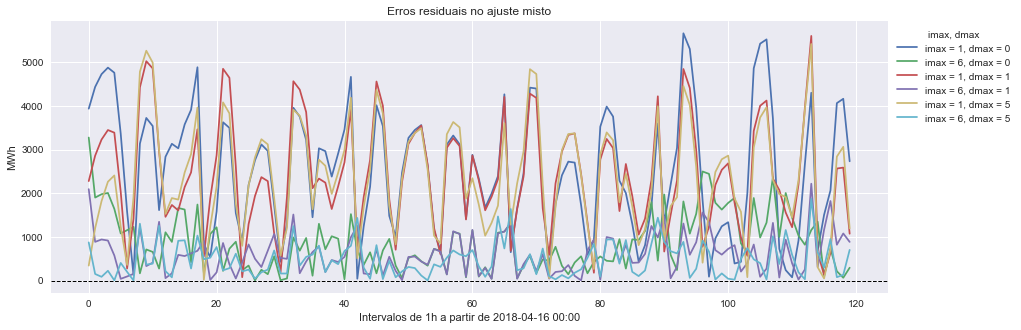

In [28]:
plt.figure(figsize=(15,5))

subts = ts[:120]
subys = ys[:120]

graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 1, 5)
graph_err(subts, subys, 24, 6, 5)

plt.axhline(color='black', linestyle='--', linewidth=1)
ax = plt.gca()
plt.show()

In [29]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 7
assert len(ax.legend().texts) == 6

O que você observou? Que melhora é obtida com o acréscimo dos polinômios da base?

Quando o valor de `imax` é $1$, a melhora é bem pequena ou até depende do intervalo, na verdade. Não sei se dá pra falar em melhora desse jeito. Quando `imax` é $6$ me parece que a melhora também não é muito expressiva não. Tem uma melhora, mas ela não parece ser muito expressiva. Com esse gráfico eu tenho a impressão que quem influencia mais na diminuição do erro é o aumento de harmônicos das funções trigonométricas e não o aumento de polinômios na base. Acho que essa é a conclusão que eu consigo tirar deles.

Faça agora dois gráficos de erro, para separar em dois grupos.

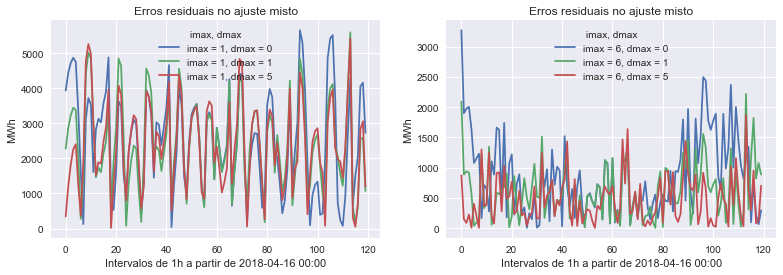

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(13,4), sharey=True)

subts = ts[:120]
subys = ys[:120]

# obs: só repeti essa função aqui pra mudar o parâmetro loc da legenda, aqui fica melhor colocar ela no meio do gráfico
def graph_err(ts, ys, p, imax, dmax):
    """Função auxiliar para gráfico de erros"""
    X = make_trig_poly(ts, p, imax, dmax)
    c, *_ = np.linalg.lstsq(X, ys, rcond=None)
    
    ajuste = ajuste_trig_poli(c, imax, ts[:tmax])
    erro = np.abs(ajuste - ys)
    
    plt.plot(ts, erro, label=f"imax = {imax}, dmax = {dmax}")

    plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00")
    plt.ylabel("MWh")
    plt.title(f'Erros residuais no ajuste misto')
    plt.legend(loc=0, title='imax, dmax')
    
plt.subplot(1, 2, 1)
graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 1, 5)

plt.subplot(1, 2, 2)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 6, 5)

- Quais são os grupos que você escolheu?
- Porquê?

Escolhi o grupo com os maiores erros e o grupo com os menores, pra observar o que acontecia de importante em cada um deles que fazia o erro ser menor. E, bom, de fato, me parece que as funções que têm o maior papel na diminuição do erro são as trigonométricas, já que as que tiveram menor erro foram as que tem o maior número de harmônicos e não as que tiveram mais polinômios na base.

É meio estranho pra mim, eu imaginava que acrescentar uma base polinomial fosse reduzir bastante os erros.